In [1]:
# Instakart market basket analysis                  #Amaresh hiremani 22

# Import statements

import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

# Reading datasets from external csv file
print('loading product prior')
pprior = pd.read_csv('order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading product train')
ptrain = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

print('loading orders')
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

print('loading products')
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])
print('loaded completely')

/home/amaresh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading product prior
loading product train
loading orders
loading products
loaded completely


In [2]:
# Preprocessing 

#checking for any null values in orders dataframe
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [3]:
# Replacing the nan values with 0 (implies it is 1st order) day_prior_order in orders and converting to type int
# because as it is first order there are no previous order dates
value = 0
orders['days_since_prior_order']=orders['days_since_prior_order'].fillna(value)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype(int)
orders.isnull().sum()                                                #Amaresh hiremani 22

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [4]:
# Computing the user details (finding the details of purchase made by each user by user_id)

# Joining orders with product prior to get product id 
print('add order info to priors')
orders.set_index('order_id', inplace=True, drop=False)
pprior = pprior.join(orders, on='order_id', rsuffix='_')
pprior.drop('order_id_', inplace=True, axis=1)

# Joining orders with product train to get product id 
print('add order info to train')
ptrain = ptrain.join(orders, on='order_id', rsuffix='_')
ptrain.drop('order_id_', inplace=True, axis=1)

# Reduce the user id to 500 to train 
limits = 500
ptrain = ptrain.loc[ptrain['user_id'] <= limits]

# Reduce the user id to 500 to test 
pprior = pprior.loc[pprior['user_id'] <= limits]

user = pd.DataFrame()

# Total number of order by users
user['total_products'] = pprior.groupby('user_id').size().astype(np.int16)

# All product_id of products purchased by users
user['products_all'] = pprior.groupby('user_id')['product_id'].apply(set)

# Distinct no of product user purchased
user['total_distinct_items'] = (user.products_all.map(len)).astype(np.int16)

# Finding average days between subsequent orders placed by same user from orders dataframe and no of orders
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

# Joining the user with usr by user_id
user = user.join(usr)
del usr
user['average_basket'] = (user.total_products / user.nb_orders).astype(np.float32)
print('number of users:', user.shape[0])

add order info to priors
add order info to train
number of users: 500


In [5]:
user.tail()

,total_products,products_all,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
496,452,"{47616, 47626, 9741, 49683, 31766, 48171, 3230...",108,3.373494,83,5.445783
497,160,"{38274, 47626, 23044, 42118, 41607, 5383, 3464...",75,10.700000,10,16.000000
498,134,"{23554, 39430, 47626, 22035, 15392, 40992, 123...",93,18.923077,13,10.307693
499,59,"{11136, 8193, 17794, 48130, 11520, 13829, 1703...",46,4.285714,7,8.428572
500,38,"{37509, 28296, 29064, 45194, 23819, 6029, 3458...",23,11.750000,4,9.500000


In [6]:
# Computing the products details 

print('computing product features')
prods = pd.DataFrame()
prods['orders'] = pprior.groupby(pprior.product_id).size().astype(np.int32)
prods['reorders'] = pprior['reordered'].groupby(pprior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

computing product features


In [7]:
products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,2.0,1.0,0.5
2,2,104,13,NaN,NaN,NaN
3,3,94,7,NaN,NaN,NaN
4,4,38,1,NaN,NaN,NaN
5,5,5,13,NaN,NaN,NaN


In [8]:
pprior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
333,40,10070,1,1,382,prior,29,1,15,23
334,40,42450,2,1,382,prior,29,1,15,23
335,40,33198,3,1,382,prior,29,1,15,23
336,40,34866,4,1,382,prior,29,1,15,23
14111,1483,32818,1,1,90,prior,31,3,13,5
14112,1483,27582,2,1,90,prior,31,3,13,5
14113,1483,12302,3,1,90,prior,31,3,13,5
14114,1483,1831,4,1,90,prior,31,3,13,5
14115,1483,19204,5,1,90,prior,31,3,13,5
14116,1483,10180,6,1,90,prior,31,3,13,5


In [9]:
# finding the total number of products
max_products = products['product_id'].max()
print('max product_id value :',max_products)
print('max of user_id :',limits)

max product_id value : 49688
max of user_id : 500


In [10]:
# Computing userXproduct details from user and product details previously obtained

print('compute userXproduct features this is long...')

# encoding the user_id and product_id into user_product because 50000 is the max value of product_id
pprior['user_product'] = pprior.product_id + pprior.user_id * 50000
d= dict()
for row in pprior.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,row.order_id,row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1, max(d[z][1], (row.order_id)),
                d[z][2] + row.add_to_cart_order)
        
print('to dataframe (less memory)')
userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product f', len(userXproduct))

del pprior

compute userXproduct features this is long...
to dataframe (less memory)
user X product f 32233


In [11]:
userXproduct.head()

,nb_orders,last_order_id,sum_pos_in_cart
19110070,14,3417147,45
19142450,15,3391810,70
19133198,19,2353996,67
19134866,18,3076789,57
4532818,28,3247417,102


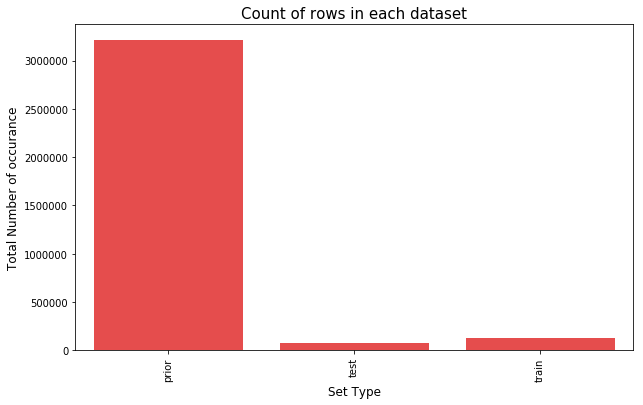

In [12]:
#different kind of evaluation set presrent in orders

count = orders.eval_set.value_counts()

plt.figure(figsize=(10,6))
sns.barplot(count.index, count.values, alpha=0.8, color='red')
plt.ylabel('Total Number of occurance', fontsize=12)
plt.xlabel('Set Type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show() 

In [13]:
# Seperation of train and test orderset from orders to make model and predict

print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

ptrain = ptrain[['order_id','product_id','add_to_cart_order','reordered']]
ptrain.set_index(['order_id', 'product_id'], inplace=True, drop=False)
train_orders = train_orders.loc[train_orders['user_id']<= limits]
test_orders = test_orders.loc[test_orders['user_id']<= limits]

split orders : train, test


In [14]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%100 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = user.products_all[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in ptrain.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(user.nb_orders)
    df['user_total_items'] = df.user_id.map(user.total_products)
    df['total_distinct_items'] = df.user_id.map(user.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(user.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(user.average_basket)
    
    print('order related features')
    df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 50000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    return (df, labels)

In [15]:
# Gathering required features and labels for given train_orders 
df_train, labels = features(train_orders, labels_given=True)

# features to be used for training the data

### eliminating user_id and userXproduct_id because they are not related with orders because user_id and userXproduct_id
### is assigned by randomly has nothing to do with product ordered by customer ###

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate'] 

build candidate list
order row 100
order row 200
order row 300
user related features
order related features
product related features
user_X_product related features


In [16]:
# Accuracy prediction for xgboost using cross-validation
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# CV model
model = xgboost.XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(model,df_train[f_to_use], labels, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 87.82% (2.44%)


In [17]:
# Accuracy prediction for lightgbm using cross-validation
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},  
    'num_leaves': 96,
    'max_depth': 46,
    'feature_fraction': 0.89,
    'bagging_fraction': 0.99,
    'bagging_freq': 10
}

lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 46,
    'num_leaves': 96, 
    'objective':'binary',
    'metric':'binary_logloss',
    'feature_fraction': 0.89,
    'bagging_fraction': 0.99,
    'max_bin': 10}

d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id']) 

### build candidates list for test 
df_test, _ = features(test_orders)

# form LightGBM datasets
# LightGBM, cross-validation
cv_result_lgb = lgb.cv(lgb_params, 
                       d_train, 
                       num_boost_round=1000, 
                       nfold=10, 
                       stratified=True, 
                       early_stopping_rounds=60, 
                       verbose_eval=150, 
                       show_stdv=True)
num_boost_rounds_lgb = len(cv_result_lgb['binary_logloss-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))

build candidate list
order row 100
user related features
order related features
product related features
user_X_product related features


/home/amaresh/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[150]	cv_agg's binary_logloss: 0.318883 + 0.00468509
[300]	cv_agg's binary_logloss: 0.278352 + 0.00659678
[450]	cv_agg's binary_logloss: 0.27484 + 0.00757179
num_boost_rounds_lgb=447


In [19]:
print('accuracy of lightgbm =',cv_result_lgb['binary_logloss-mean'][0]*100)

accuracy of lightgbm = 68.6317889668


In [35]:
## methods involved super vector network,binary classification and binary logloss ##
# binary logloss is used because values will be between 0 to 1 
# instead directly 0 or 1 which increases accuracy of prediction by setting threshold.


## Importance of using the Light gradient boosting compaired to other in this project ##

# Faster training speed and higher efficiency.
# Lower memory usage.
# Better accuracy than any other boosting algorithm.
# Large datasets is compatible with lightgbm


# Light gradient boosting implementation

print('formating for lgb')
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  
# can include 'order_hour_of_day', 'dow' in categrical features 

print('finish buillding candidate list')

# Have to check for different values for best fit before declaring.
# num_leaves : number of leaves in one tree ; default = 31 ; type =int.
# max_depth: Specify the max depth to which tree will grow. This parameter is used to deal with overfitting.
# feature_fraction: default=1 ; specifies the fraction of features to be taken for each iteration
# bagging_fraction: default=1 ; specifies the fraction of data to be used for each iteration 
#and is generally used to speed up the training and avoid overfitting.

# Training and Testing for given datasets

ROUNDS = 100
print('light GBM train :-)')
bst = lgb.train(lgm_params, d_train, ROUNDS

print('light GBM predict')
preds = bst.predict(df_test[f_to_use])

df_test['pred'] = preds



# Xg boosting implementation 
# alogrithm/objective used is binary classification to classify whether product_id appears in next order 

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, objective='binary:logistic').fit(df_train[f_to_use],labels)
preds2 = gbm.predict(df_test[f_to_use])
df_test['pred2'] = preds2


TRESHOLD = 0.20  # minimal logloss-value for each order_id in lgm

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'
        
d2 = dict()
for row in df_test.itertuples():
    if row.pred2 > 0:                  # value should be 1 for each order_id in xgboost
        try:
            d2[row.order_id] += ' ' + str(row.product_id)
        except:
            d2[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d2:
        d2[order] = 'None'
        
# Output submission file contains test order_id and its predicted product_id

submission = pd.DataFrame.from_dict(d, orient='index')

submission.reset_index(inplace=True)
submission.columns = ['order_id', 'products']
submission.to_csv('sub_lgbboost.csv', index=False)

submission2 = pd.DataFrame.from_dict(d2, orient='index')
submission2.reset_index(inplace=True)
submission2.columns = ['order_id', 'products']
submission2.to_csv('subm_xgboost.csv', index=False)
print('submission file generated for both xgboost and lightgbm \n finished...')

formating for lgb
finish buillding candidate list
light GBM train :-)


/home/amaresh/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


build candidate list
order row 100
user related features
order related features
product related features
user_X_product related features
light GBM predict
submission file generated for both xgboost and lightgbm 
 finished...


In [36]:
df_test.head(10)

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,dow,order_hour_of_day,days_since_prior_order,...,product_orders,product_reorders,product_reorder_rate,z,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,pred,pred2
0,2774568,17668,13,88,33,11.076923,6.769231,5,15,11,...,6,4.0,0.666667,167668,5,0.384615,3.600000,0.384615,0.372934,0
1,2774568,44683,13,88,33,11.076923,6.769231,5,15,11,...,70,48.0,0.685714,194683,2,0.153846,9.500000,0.153846,0.135999,0
2,2774568,48523,13,88,33,11.076923,6.769231,5,15,11,...,11,3.0,0.272727,198523,2,0.153846,6.500000,0.153846,0.082412,0
3,2774568,21903,13,88,33,11.076923,6.769231,5,15,11,...,576,439.0,0.762153,171903,8,0.615385,4.250000,0.615385,0.477020,1
4,2774568,14992,13,88,33,11.076923,6.769231,5,15,11,...,56,31.0,0.553571,164992,2,0.153846,7.000000,0.153846,0.104981,0
5,2774568,21137,13,88,33,11.076923,6.769231,5,15,11,...,663,521.0,0.785822,171137,1,0.076923,7.000000,0.076923,0.106776,0
6,2774568,32402,13,88,33,11.076923,6.769231,5,15,11,...,5,2.0,0.400000,182402,3,0.230769,8.333333,0.230769,0.186531,0
7,2774568,22035,13,88,33,11.076923,6.769231,5,15,11,...,135,100.0,0.740741,172035,3,0.230769,3.666667,0.230769,0.231454,0
8,2774568,49683,13,88,33,11.076923,6.769231,5,15,11,...,274,197.0,0.718978,199683,1,0.076923,4.000000,0.076923,0.163881,0
9,2774568,39190,13,88,33,11.076923,6.769231,5,15,11,...,30,19.0,0.633333,189190,10,0.769231,1.800000,0.769231,0.631636,1


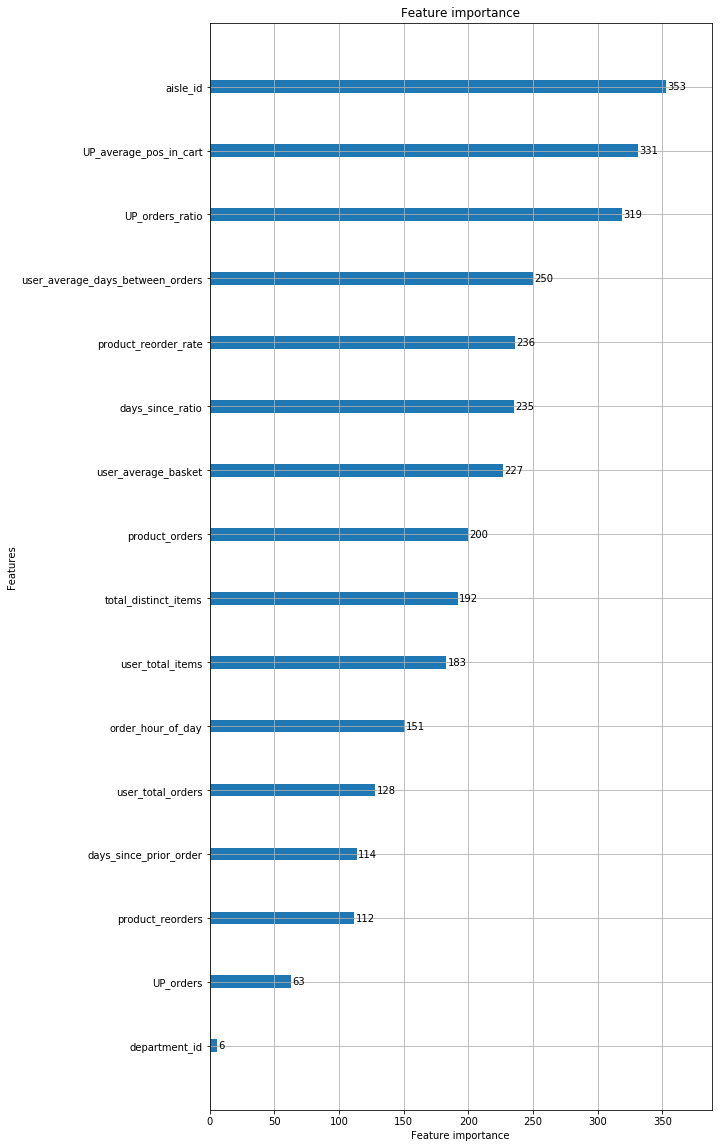

In [57]:
# Feature and its importance for better tuning of parameters

lgb.plot_importance(bst, figsize=(9,20))